# Spectral analysis of local field potentials
This tutorial covers the spectral analysis of local field potentials (LFPs). It demonstrates this using both the short-time Fourier transform and wavelets. In addition, we make use of the xarray data type, which is good when working with multidimensional arrays whose axes can have multiple meanings. For more information about xarrays, see their [documentation](https://tutorial.xarray.dev/overview/xarray-in-45-min.html).

To learn the basics of conventional spectral analysis, you can check out one of my [lectures](https://github.com/dbheadley/DecodingTheBrain/blob/main/Week6/notes.ipynb).

For a more advanced and comprehensive discussion of spectral analysis, this [online textbook](https://brianmcfee.net/dstbook-site/content/intro.html) is exceptionally helpful and well illustrated.

Also, check out the [pywavelets documentation](https://pywavelets.readthedocs.io/en/latest/index.html) to learn more!



In [7]:
import os
import dclut as dcl
import numpy as np
import xarray as xr
import pynapple as nap
import scipy.signal as ss
import matplotlib.pyplot as plt
from scipy.stats import zscore
from mimo_pack.plot.map import wave_map_xr, amp_map_xr
from mimo_pack.plot.dclut import probe_layout, unit_lfp_mapping
from mimo_pack.analysis.probe import nearest_grid, find_lfp_channel
from mimo_pack.analysis.spectral import stft_xr, wavelet_xr,\
    fit_spectrum_aperiodic_xr,  wavelet_phamp_xr, compute_spike_phamp_hist

In [8]:
# path to LFP dclut file goes here
lfp_path = os.path.join('D:', 'SortingTemp', '24-05-31_DH23_A1-IC_g0', 
                         '24-05-31_DH23_A1-IC_g0_imec0', 
                         '24-05-31_DH23_A1-IC_g0_t0.imec0.lfp_dclut.json')

## Setting up dclut file and deciding what LFP data to laod
Loading all recorded LFP data from a single session is often impractical due to the data size. This because especially problematic if you want to save wavelet spectrograms for all that data, since each data point is now stored as a complex number (which usually has twice the bytes) and for every frequency. However, since the LFP is often similar between adjacent electrodes, one can instead load a subset of the channels that are spaced far enough apart that they will tend to be less correlated. In most cases, a spacing of ~100 microns along both the x and y directions is satisfactory.

Let's start by setting up our dclut object for the LFP data and visualizing the locations of the electrodes.

<Axes: xlabel='X Position (um)', ylabel='Y Position (um)'>

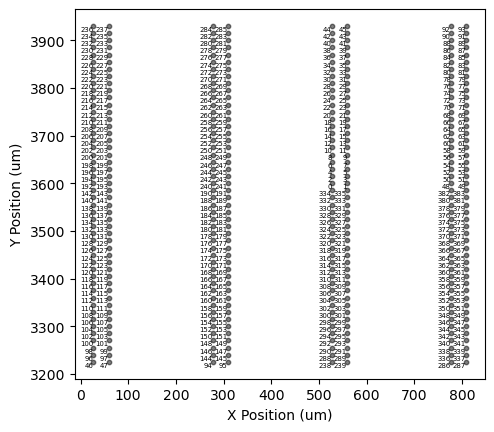

In [9]:
lfp_dcl = dcl.dclut(lfp_path)

probe_layout(lfp_dcl)

We will now create a grid of points that tile the area encompassed by the electrodes. We will start the grid with the 'lower left' point, and tile it across the entire area spanned by the electrodes. When setting the grid spacing, keep the arrangement of the electrodes in mind. I have created a function, `nearest_grid`, that returns the channels on a probe (specified by the dclut object), that are closest to points on a grid. For this example, 100 microns will work along the y-axis, but along the x-axis the spacing should be 250 microns.

Text(0.5, 1.0, 'Nearest grid points')

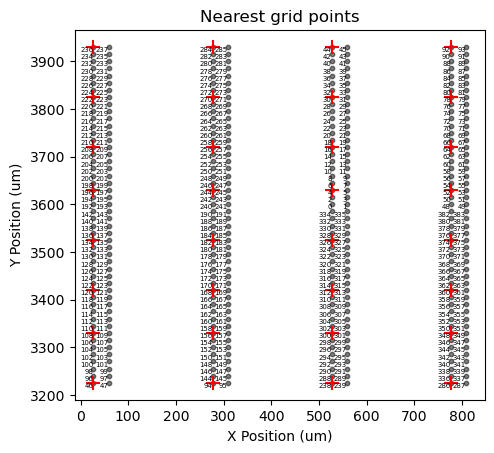

In [10]:
ch_grid, x_grid, y_grid = nearest_grid(lfp_dcl, dx=250, dy=100)

# plot the grid points
ax = probe_layout(lfp_dcl)
ax.scatter(x_grid, y_grid, s=100, c='r', marker='+')
ax.set_title('Nearest grid points')

Now we just need to use those channels when selecting the electrodes whose signal we will load. We will read it in as an xarray object. These are multidimensional arrays that contain additional metadata specifing the values and names of dimensions. In brief, each dimension of the array has a name (e.g. 'time', 'channel'), and can have coordinates overlaid on them. For instance, our `lfp` xarray has a 'channel' dimension with coordinates for the x and y positions of each channel.

In [11]:
# get the time values in our recording
t = lfp_dcl.scale_values('time')

# find last value of t that is not a nan
t_max = t[np.where(~np.isnan(t))[0][-1]-1]

# load the LFP data
lfp_dcl.reset()
lfp_dcl.points(select={'channel': ch_grid})
lfp_dcl.intervals(select={'time': [[0, t_max]]})
lfp = lfp_dcl.read(format='xarray')[0]

Note that we excluded the end of the recording where the time points were labeled with NaNs. This is because when we want to select time slices from the LFP xarray object (`lfp`), we need all time points to be monotonically increasing. 

You can see the dimensions and coordinates of the xarray object using the print function.

In [12]:
print(lfp)

<xarray.DataArray (time: 27011665, channel: 32)> Size: 2GB
array([[283, 264, 243, ..., 289, 309, 311],
       [288, 262, 237, ..., 282, 301, 302],
       [283, 258, 240, ..., 281, 302, 303],
       ...,
       [ 18, -36, -26, ...,  16,  61,   8],
       [ 24, -30, -20, ...,  19,  65,  16],
       [ 31, -24,  -8, ...,  25,  71,  21]],
      shape=(27011665, 32), dtype=int16)
Coordinates:
  * time      (time) float64 216MB 0.0 0.0009998 0.002 ... 2.701e+04 2.701e+04
  * channel   (channel) int64 256B 4 16 30 44 46 52 ... 300 312 326 348 360 374
    ch_name   (channel) <U9 1kB 'AP4;4' 'AP16;16' ... 'AP360;360' 'AP374;374'
    ch_order  (channel) int64 256B 246 258 272 286 0 342 ... 218 232 302 314 328
    ch_x      (channel) float64 256B 527.0 527.0 527.0 ... 777.0 777.0 777.0
    ch_y      (channel) float64 256B 3.63e+03 3.72e+03 ... 3.42e+03 3.525e+03
    ch_shank  (channel) float64 256B 2.0 2.0 2.0 2.0 0.0 ... 2.0 2.0 3.0 3.0 3.0
    s0        (time) int64 216MB 0 1 2 3 ... 27011661 27

The top line lists the dimensions and the number of indices each of them has. Below that is a snippet of the data, and below that is a list of the coordinate names and their corresponding dimension in parentheses. Note that the object size is 2 GB. If we included all 384 channels, that would be $2GB \times \frac{384}{32}=24GB$. Not prohibitive, but excessive, especially considering how correlated the LFP is between sites on the order of 100 um.

With the data loaded, let's inspect it. We will plot a short segment of the LFP signal from each electrode, positioned where the electrode is. To do this, we will use the `wave_map_xr` function in mimopack. It allows you to directly pass an xarray object with time and channel that has positional coordinates.

Text(0, 0.5, 'Y position (um)')

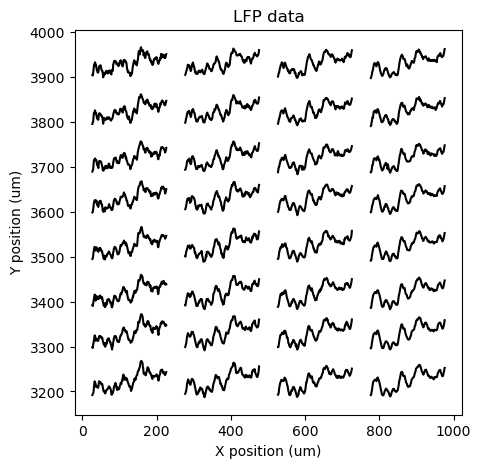

In [7]:
# select a time segment of the LFP data
t = lfp.time.values
t_start = 300.0
t_end = 300.2
sample = lfp.sel(time=slice(t_start, t_end))

# remove the mean voltage from each channel, to avoid DC offset
sample = sample - sample.mean(dim='time')

# plot the LFP data
fig, ax = plt.subplots(figsize=(5, 5))
wave_map_xr(sample, ax=ax, y_scale=0.5)
ax.set_title('LFP data')
ax.set_xlabel('X position (um)')
ax.set_ylabel('Y position (um)')

## Spectral analysis with short-time fourier transform
With our data now loaded, we can perform spectral analysis. To start, we will calculate the power spectrum of the LFP on each electrode. To do this, we will use the short-time Fourier transform. It applies a fourier transform to short windows of data (typically 1 second), stepping across the entire recording duration. There are a few advantages to this approach. First, it can give a high frequency resolution. For instance, a 1 second window will yield a frequency resolution of 1 Hz (1/1sec). The maximum frequency it can measure is half the sample rate. Typically we have a 1kHz sample rate for LFPs, so the maximum frequency will be 500 Hz. Second, since a spectrum is only calculated for each window, it will not take up too much memory. Third, since the power spectrum is calculated for a series of windows spanning our recording, we can visually inspect changes in it across the entire session. This is especially useful if we want to identify diffrent behavioral states, such as sleeping versus active waking.

To calculate the short-time Fourier transform, we will use the convenience function `stft_xr` found in mimopack. It allows you to directly pass an x-array object to the `ShortTimeFFT` class in Scipy. It identifies the time dimension in the inputted xarray, calculates the short-time Fourier transform along it for every other dimension (e.g. each channel), and returns another xarray object with a frequency dimension added to the end. In this case, the spectral data is a 3D array with axes [time, channel, frequency].

In [8]:
# Apply STFT to the signal
lfp_s = stft_xr(lfp, window=1.0)

Let's now inspect the result for a single channel at a single time point.

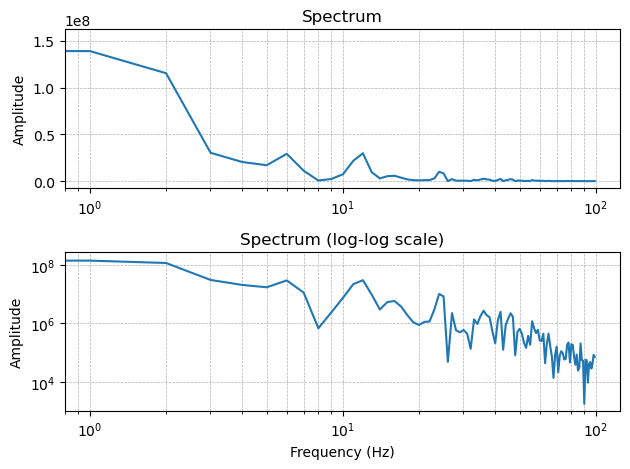

In [9]:
sample = lfp_s.sel(time=100, channel=16, method='nearest').sel(frequency=slice(0, 100))
fig, ax = plt.subplots(2,1)
ax[0].plot(sample.frequency.values, sample.values)
ax[0].set_ylabel('Amplitude')
ax[0].set_title('Spectrum')
ax[0].set_xscale('log')
ax[0].grid(which='both', linestyle='--', linewidth=0.5)

ax[1].plot(sample.frequency.values, sample.values)
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Amplitude')
ax[1].set_title('Spectrum (log-log scale)')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].grid(which='both', linestyle='--', linewidth=0.5)
fig.tight_layout()


When visualizing spectral power, we should apply a log transform because the power falls off exponentially as power increases, making it difficult to see any changes at higher frequencies.

Now let's plot the power spectrum across time.

Text(0.5, 1.0, 'STFT of LFP signal')

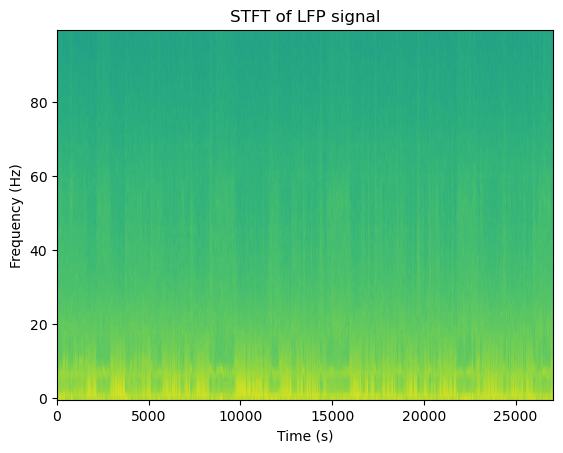

In [10]:
sample = lfp_s.sel(channel=16, frequency=slice(None,100))
fig, ax = plt.subplots()
ax.imshow(np.log(sample).T, aspect='auto',vmax=20)
ax.invert_yaxis()
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (Hz)')
ax.set_title('STFT of LFP signal')

 Even with the power log transformed, notice that it is difficult to see any changes in the spectrum across time. This is because the power spectrum is dominated by a *1/f* or *aperiodic* component. This corresponds to a linear decrease in power with frequency when the spectrum is plotted on a log-log plot. We can see this clearly if we look at the mean power spectrum on this channel across the entire recording session.

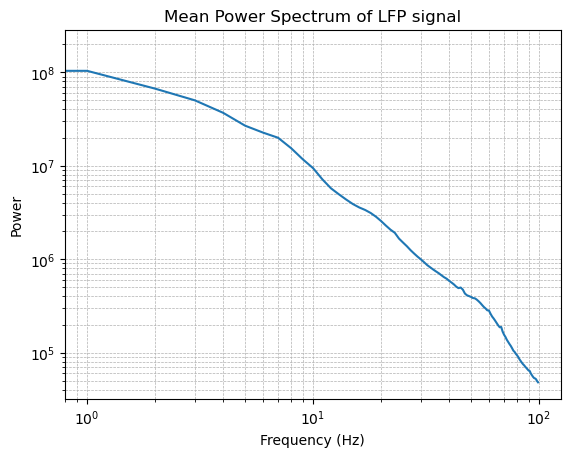

In [11]:
mean_spec = sample.mean(dim='time')
freqs = mean_spec.frequency
fig, ax = plt.subplots()
ax.plot(freqs, mean_spec)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power')
ax.set_title('Mean Power Spectrum of LFP signal')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

We can account for the aperiodic component by fitting a curve to it. In mimopack there is a function just for this, `fit_spectrum_aperiodic`. Once the aperiodic component is fitted, you can calculate the relative change in spectral power from the aperiodic component.

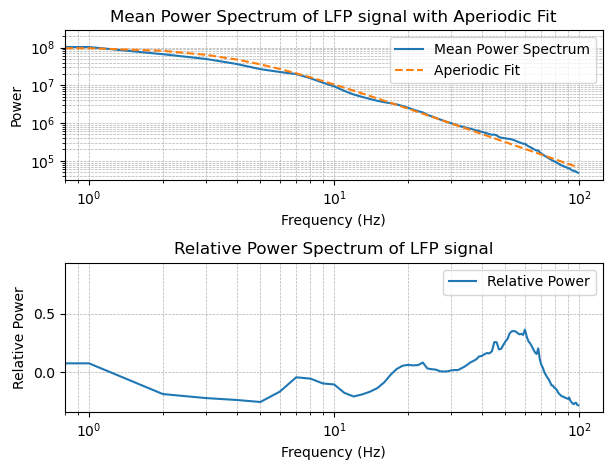

In [12]:
mean_spec_ap = fit_spectrum_aperiodic_xr(mean_spec)

fig, ax = plt.subplots(2,1)
ax[0].plot(freqs, mean_spec, label='Mean Power Spectrum')
ax[0].plot(freqs, mean_spec_ap, label='Aperiodic Fit', linestyle='--')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('Power')
ax[0].set_title('Mean Power Spectrum of LFP signal with Aperiodic Fit')
ax[0].legend()
ax[0].grid(True, which='both', linestyle='--', linewidth=0.5)

ax[1].plot(freqs, (mean_spec - mean_spec_ap) / mean_spec_ap, label='Relative Power')
ax[1].set_xscale('log')
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Relative Power')
ax[1].set_title('Relative Power Spectrum of LFP signal')
ax[1].legend()
ax[1].grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

The curve of relative power exhibits several 'bumps'. Their peak frequencies are ones that correspond to known rhythmic components in the LFP signal. In particular, you can see bumps around 7 Hz (theta), 20 Hz (beta), and 52 Hz (gamma). You should also note several sharp, but small, peaks. One of these is at 60 Hz and likely corresponds to the 60 Hz power line artifact. The others are at multiples of ~22 Hz, and may reflect some other source of electrical noise that is not power line related. Thankfully, the amplitude of these is relatively minor, so we will ignore them.

Seeing how removal of the aperiodic component brings out rhythmic features in the power spectrum, we can apply the same calculation to every time window in our short-time Fourier transformed spectrogram.

In [13]:
lfp_s_ap = fit_spectrum_aperiodic_xr(lfp_s, f_range=[0, 100], suppress_error=True)

c:\users\dbh60\documents\mimo\mimo_pack\mimo_pack\math\curvefitting.py:159: RuntimeWarning: invalid value encountered in log10
  return offset - np.log10(knee + x**exp)


Error fitting exp_knee: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Error fitting exp_knee: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Error fitting exp_knee: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Error fitting exp_knee: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Error fitting exp_knee: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Error fitting exp_knee: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Error fitting exp_knee: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Error fitting exp_knee: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Error fitting exp_knee: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Error fitting exp_knee: Opti

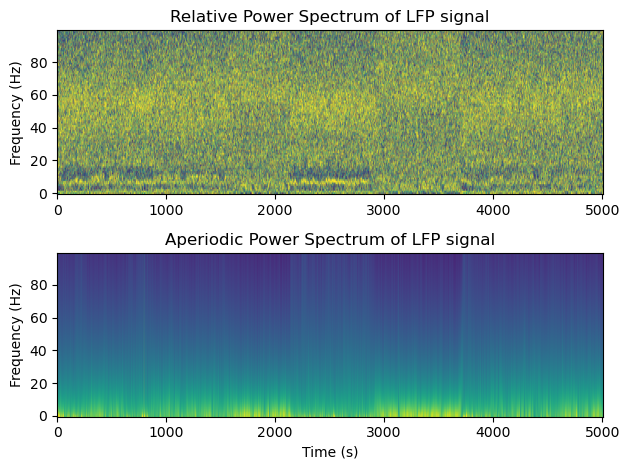

In [14]:
rel_spec = (lfp_s - lfp_s_ap) / lfp_s_ap
sample_dict = {'channel': 16, 
                'time': slice(None,5000), 
                'frequency': slice(None, 100)}
fig, ax = plt.subplots(2,1)
ax[0].imshow(rel_spec.sel(**sample_dict).T, aspect='auto', vmax=1, vmin=-1)
ax[0].invert_yaxis()
ax[0].set_ylabel('Frequency (Hz)')
ax[0].set_title('Relative Power Spectrum of LFP signal')

ax[1].imshow(np.log(lfp_s_ap.sel(**sample_dict).T), aspect='auto', vmax=20)
ax[1].invert_yaxis()
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Frequency (Hz)')
ax[1].set_title('Aperiodic Power Spectrum of LFP signal')
plt.tight_layout()

We can now clearly see that there are two kinds of activity. Focusing on the graph of relative power (proportional change from aperiodic), some periods exhibit elevated power in the theta, beta, and gamma bands. This likely corresponds to active waking. The other shows some broadband power increases around 60 Hz, but nothing else. Examining the fited aperiodic power spectrogram graph, those epochs show elevated low frequency power. This likely reflects quiet waking or sleeping.

So far we have focused on the power spectrum from a single electrode, and found that it changes across time. During active periods it shows a prominent gamma bump. But does this gamma vary across electrodes? To examine that, we will get the mean power spectrum for each channel, measure deviation from the aperiodic component, and then plot the strength of the gamma bump for each site.

Text(0, 0.5, 'Channel Y Position (um)')

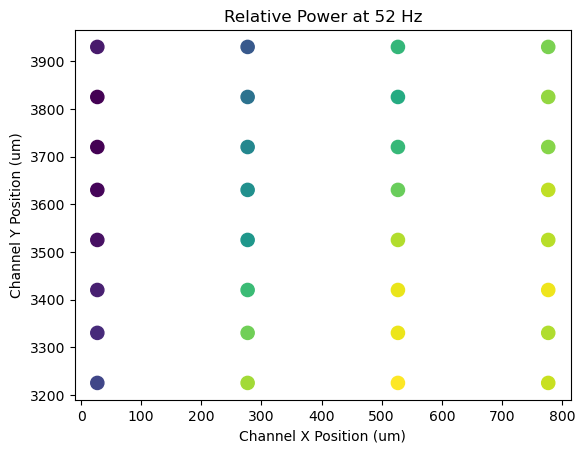

In [15]:
# mean spectrum across time for each channel
# note that xarrays support many operations like numpy, returning
# a new xarray with the same dimensions as the original, but with the
# specified dimension reduced to a single value
mean_spec_ch = lfp_s.mean(dim='time')

# calculate the aperiodic fit for the mean spectrum
mean_spec_ch_ap = fit_spectrum_aperiodic_xr(mean_spec_ch, f_range=[0, 100])

# get the relative power spectrum for each channel
rel_spec_ch = (mean_spec_ch - mean_spec_ch_ap) / mean_spec_ch_ap

fig, ax = plt.subplots()
amp_map_xr(rel_spec_ch.sel(frequency=52, method='nearest'), vmax=0.4, ax=ax)
ax.set_title('Relative Power at 52 Hz')
ax.set_xlabel('Channel X Position (um)')
ax.set_ylabel('Channel Y Position (um)')

## Wavelet analysis of LFPs
One drawback to the short-time Fourier transform approach is that you cannot track momentary changes in spectral properties for time scales shorter than your time window. The power of brain rhythms tend to fluctuate on the timescale of a few hundred milliseconds. And their phase, especially at higher frequencies, vary from moment to moment. To capture these short time scale dynamics we can use wavelets.

In [16]:
lfp_w = wavelet_xr(lfp.sel(channel=16))

The wavelet spectrogram gives a complex number for each time/frequency combination. By taking the absolute value, you get the magnitude of the spectral power. To get the phase, calculate the angle of the complex number. At phase = 0 radians you are at the positive peak of a cycle. The negative peak is at -pi or pi (they are effectively equivalent).

In [17]:
# get spectral amplitude
lfp_w_amp = np.abs(lfp_w)

# get spectral phase 
# (for unclear reasons, applying np.angle directly to
# the xarray DataArray does not work, so we create a copy
# and then apply np.angle to the values)
lfp_w_ph = lfp_w.copy(deep=True)
lfp_w_ph.values = np.angle(lfp_w.values)

When plotting the wavelet spectrogram, you should limit yourself to short sections of time. It can be cumbersome to show more than 10 seconds. In addition, when plotting the magnitude, we have the same problem with the rapid falloff in power with increasing frequency. Applying the log transform will still leave us with the aperiodic combponent obscuring oscillatory bumps, and the aperiodic fit tends not to work for spectra sampled instantaneously at each time step. Instead, use a z-transform across time for each frequency to put them all on the same range of values.

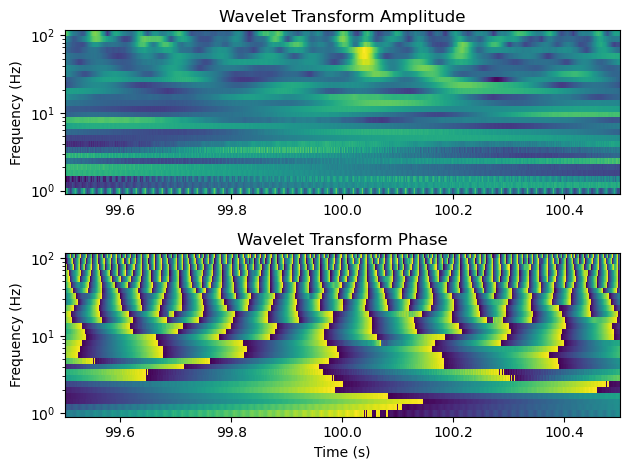

In [18]:
sample_amp = lfp_w_amp.sel(time=slice(99.5, 100.5))
sample_ph = lfp_w_ph.sel(time=slice(99.5, 100.5))

fig, ax = plt.subplots(2,1)
ax[0].pcolormesh(sample_amp.time, sample_amp.frequency, 
                 zscore(sample_amp.T,axis=1))
ax[0].set_yscale('log')
ax[0].set_ylabel('Frequency (Hz)')
ax[0].set_title('Wavelet Transform Amplitude')
ax[1].pcolormesh(sample_ph.time, sample_ph.frequency, 
                 sample_ph.T)
ax[1].set_yscale('log')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Frequency (Hz)')
ax[1].set_title('Wavelet Transform Phase')
plt.tight_layout()

Note how low frequencies vary more slowly in their power than high ones. This make sense since a slower process likely underlies a low frequency rhythm than a fast one. Less used in neuroscience is the phase plot of a wavelet spectrogram. Here you see a ramping of color from blue to yellow, followed by an instantaneous flip back to blue. This is the phase varying from -pi to pi, and then circling back to -pi.

Just as with the short-time Fourier transform, we can calculate the mean spectrum, its aperiodic component, and deviation from it.

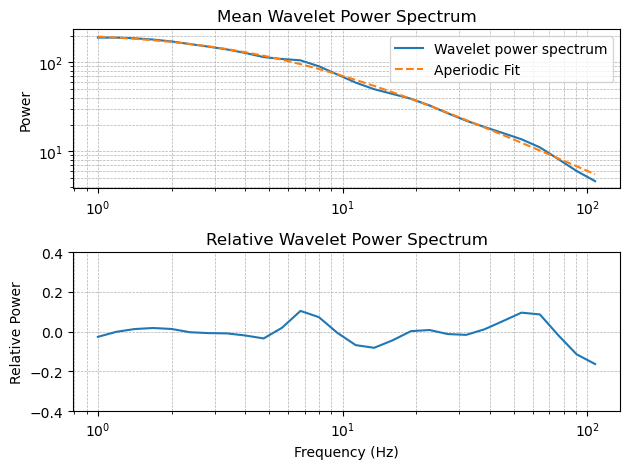

In [19]:
# get mean spectrum across from entire recording
spec_w = lfp_w_amp.mean(dim='time')

# fit the aperiodic component of the wavelet spectrum
spec_w_ap = fit_spectrum_aperiodic_xr(spec_w, f_range=[0, 100])

# calculate the relative power spectrum
rel_spec_w = (spec_w - spec_w_ap) / spec_w_ap

fig, ax = plt.subplots(2,1)
ax[0].plot(spec_w.frequency, spec_w, label='Wavelet power spectrum')
ax[0].plot(spec_w.frequency, spec_w_ap, label='Aperiodic Fit', linestyle='--')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylabel('Power')
ax[0].set_title('Mean Wavelet Power Spectrum')
ax[0].grid(True, which='both', linestyle='--', linewidth=0.5)
ax[0].legend()

ax[1].plot(spec_w.frequency, rel_spec_w, label='Relative Power')
ax[1].set_xscale('log')
ax[1].set_ylim(-0.4, 0.4)
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Relative Power')
ax[1].set_title('Relative Wavelet Power Spectrum')
ax[1].grid(True, which='both', linestyle='--', linewidth=0.5)
fig.tight_layout()


The wavelet yields a similar spectrum to what we saw with the short-time Fourier transform. The major difference is that the narrowband peaks reflecting electrical artifacts (e.g. powerline noise) are not visible. This is because the wavelets, by virtue of only sampling a certain frequency for a short period of time, have a wider bandwidth than a sine wave over a 1 second window.

## Examining unit entrainment
A major advantage of calculating a wavelet spectrogram is that you get samples of spectral power and phase at each time step. If you select those time steps when a particular neuron spiked, you can determine if they fire preferentially particular rhythms phase or amplitude.

To do this, let's first load in some spike times recorded from the probe.

In [13]:
su_path = os.path.join('D:', 'AudAD', 'project', 'data', 
                       '24-05-31_DH23_A1-IC_g0_t0_imec0.ap.su.npz')
su_file = nap.io.NPZFile(su_path)
su = su_file.load()

Before we relate spiking to LFP rhythms, we need to decide what LFP channel to use. For a given channel, if a single unit is within ~100 um of it, then the spike waveform will contribute to the LFP signal and distort our measures of entrainment. On the other hand, if the unit is more than 200 um, than the LFP will be less reflective of its subthreshold activity. To compromise, we analyze those units between 100 and 200 um from a selected chane

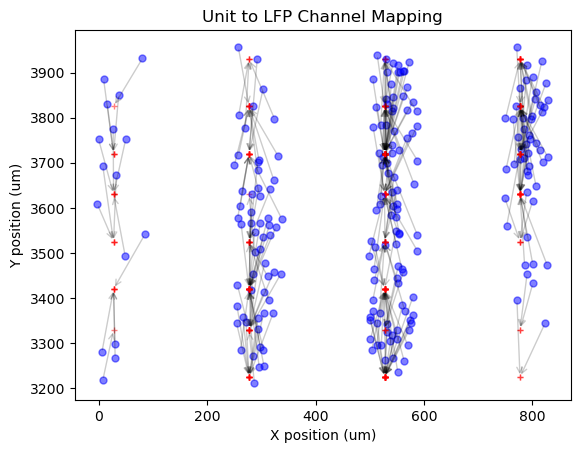

In [14]:
su = find_lfp_channel(su, lfp)
ax = unit_lfp_mapping(su, lfp)

Looks like the units were correctly matched to LFP channels. Now let's separate our units into groups based on the LFP channel they matched with, and then calculate their entrainment to gamma.

In [221]:
# compute the spike wavelet histograms
spike_hist = compute_spike_phamp_hist(su, lfp, bins=(4, 9), freqs=[7,20,52])

Now let's plot the entrainment of an exemple unit.

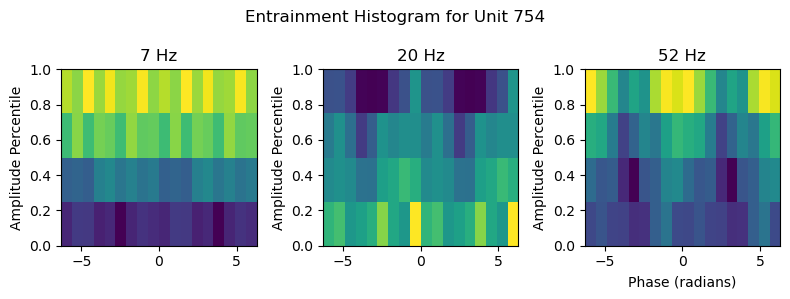

In [464]:
fig, ax = plt.subplots(1,3,figsize=(8, 3))
ent = spike_hist.loc[754]
for i, f in enumerate(ent.frequency.values):
    data = ent.sel(frequency=f).to_numpy()
    ax[i].imshow(np.tile(data, (1, 2)),
            extent=[-2*np.pi, 2*np.pi, 0, 1],
            aspect='auto', origin='lower',)
    ax[i].set_ylabel('Amplitude Percentile')
    ax[i].set_title(f'{f} Hz')
ax[-1].set_xlabel('Phase (radians)')
fig.suptitle(f'Entrainment Histogram for Unit {754}')
fig.tight_layout()